# MNIST handwritten digits classification with MLPs

In this notebook, we'll train a multi-layer perceptron model to classify MNIST digits using **PyTorch**. 

First, the needed imports. 

In [7]:
%matplotlib inline
import os    
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from timm.models.layers import DropPath, trunc_normal_

import numpy as np
import matplotlib.pyplot as plt

if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
    
print('Using PyTorch version:', torch.__version__, ' Device:', device)

Using PyTorch version: 1.13.0+cu117  Device: cuda


## Data

Next we'll load the MNIST data.  First time we may have to download the data, which can take a while.

Note that we are here using the MNIST test data for *validation*, instead of for testing the final model.

In [8]:
batch_size = 32

train_dataset = datasets.MNIST('./data', 
                               train=True, 
                               download=True, 
                               transform=transforms.ToTensor())

validation_dataset = datasets.MNIST('./data', 
                                    train=False, 
                                    transform=transforms.ToTensor())

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=batch_size, 
                                           shuffle=True)

validation_loader = torch.utils.data.DataLoader(dataset=validation_dataset, 
                                                batch_size=batch_size, 
                                                shuffle=False)

The train and test data are provided via data loaders that provide iterators over the datasets. The first element of training data (`X_train`) is a 4th-order tensor of size (`batch_size`, 1, 28, 28), i.e. it consists of a batch of images of size 1x28x28 pixels. `y_train` is a vector containing the correct classes ("0", "1", ..., "9") for each training digit.

In [9]:
for (X_train, y_train) in train_loader:
    print('X_train:', X_train.size(), 'type:', X_train.type())
    print('y_train:', y_train.size(), 'type:', y_train.type())
    break

X_train: torch.Size([32, 1, 28, 28]) type: torch.FloatTensor
y_train: torch.Size([32]) type: torch.LongTensor


Here are the first 10 training digits:

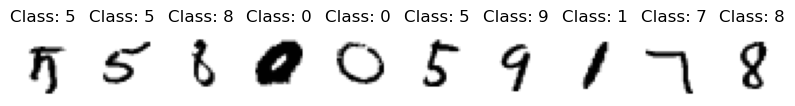

In [10]:
pltsize=1
plt.figure(figsize=(10*pltsize, pltsize))

for i in range(10):
    plt.subplot(1,10,i+1)
    plt.axis('off')
    plt.imshow(X_train[i,:,:,:].numpy().reshape(28,28), cmap="gray_r")
    plt.title('Class: '+str(y_train[i].item()))

## ViP NetWork

In [51]:
class Mlp(nn.Module):
    def __init__(self, in_features, hidden_features=None, out_features=None, act_layer=nn.GELU, drop=0.):
        super().__init__()
        out_features = out_features or in_features
        hidden_features = hidden_features or in_features
        self.fc1 = nn.Linear(in_features, hidden_features)
        self.act = act_layer()
        self.fc2 = nn.Linear(hidden_features, out_features)
        self.drop = nn.Dropout(drop)

    def forward(self, x):
        x = self.fc1(x)
        x = self.act(x)
        x = self.drop(x)
        x = self.fc2(x)
        x = self.drop(x)
        return x


class WeightedPermuteMLP(nn.Module):
    def __init__(self, dim, segment_dim=7, proj_drop=0.):
        super().__init__()
        self.segment_dim = segment_dim

        self.mlp_c = nn.Linear(dim, dim)
        self.mlp_h = nn.Linear(dim, dim)
        self.mlp_w = nn.Linear(dim, dim)

        self.reweight = Mlp(dim, dim // 4, dim * 3)

        self.proj = nn.Linear(dim, dim)
        self.proj_drop = nn.Dropout(proj_drop)

    def forward(self, x):
        B, H, W, C = x.shape

#         print(x.shape)
        S = C // self.segment_dim
#         print(S, C, self.segment_dim)
        h = x.reshape(B, H, W, self.segment_dim, S).permute(
            0, 3, 2, 1, 4).reshape(B, self.segment_dim, W, H*S)
#         print(h.shape)
        h = self.mlp_h(h).reshape(B, self.segment_dim, W, H, S).permute(
            0, 3, 2, 1, 4).reshape(B, H, W, C)

        w = x.reshape(B, H, W, self.segment_dim, S).permute(
            0, 1, 3, 2, 4).reshape(B, H, self.segment_dim, W*S)
        w = self.mlp_w(w).reshape(B, H, self.segment_dim, W, S).permute(
            0, 1, 3, 2, 4).reshape(B, H, W, C)

        c = self.mlp_c(x)

        a = (h + w + c).permute(0, 3, 1, 2).flatten(2).mean(2)
        a = self.reweight(a).reshape(B, C, 3).permute(
            2, 0, 1).softmax(dim=0).unsqueeze(2).unsqueeze(2)

        x = h * a[0] + w * a[1] + c * a[2]

        x = self.proj(x)
        x = self.proj_drop(x)

        return x


class PermutatorBlock(nn.Module):

    def __init__(self, dim, segment_dim, mlp_ratio=3.,
                 act_layer=nn.GELU, norm_layer=nn.LayerNorm, skip_lam=1.0, mlp_fn=WeightedPermuteMLP):
        super().__init__()
        self.norm1 = norm_layer(dim)
        self.attn = mlp_fn(dim, segment_dim=segment_dim)

        self.drop_path = nn.Identity()

        self.norm2 = norm_layer(dim)
        mlp_hidden_dim = int(dim * mlp_ratio)
        self.mlp = Mlp(in_features=dim,
                       hidden_features=mlp_hidden_dim, act_layer=act_layer)
        self.skip_lam = skip_lam

    def forward(self, x):
        x = x + self.drop_path(self.attn(self.norm1(x))) / self.skip_lam
        x = x + self.drop_path(self.mlp(self.norm2(x))) / self.skip_lam
        return x


class PatchEmbed(nn.Module):
    """ Image to Patch Embedding
    """

    def __init__(self, img_size=28, patch_size=7, in_chans=1, embed_dim=56):
        super().__init__()
        self.proj = nn.Conv2d(in_chans, embed_dim, kernel_size=(
            img_size // patch_size), stride=(img_size // patch_size))

    def forward(self, x):
#         print(x.shape)
        x = self.proj(x)  # B, C, H, W
        return x

def basic_blocks(dim, index, layers, segment_dim, mlp_ratio=3.,
                 skip_lam=1.0, mlp_fn=WeightedPermuteMLP, **kwargs):
    blocks = []

    for block_idx in range(layers[index]):
        blocks.append(PermutatorBlock(dim, segment_dim, mlp_ratio=mlp_ratio,
                                      skip_lam=skip_lam, mlp_fn=mlp_fn))

    blocks = nn.Sequential(*blocks)

    return blocks


class VisionPermutator(nn.Module):
    """ Vision Permutator
    """

    def __init__(self, layers, img_size=28, patch_size=7, in_chans=1, num_classes=10,
                 embed_dims=None, segment_dim=None,
                 norm_layer=nn.LayerNorm, mlp_fn=WeightedPermuteMLP):

        super().__init__()
        self.num_classes = num_classes

        self.patch_embed = PatchEmbed(
            img_size=img_size, patch_size=patch_size, in_chans=in_chans, embed_dim=embed_dims[0])

        network = []
        for i in range(len(layers)):
            stage = basic_blocks(embed_dims[i], i, layers, segment_dim[i],
                                 norm_layer=norm_layer,
                                 mlp_fn=mlp_fn)
            network.append(stage)

        self.network = nn.ModuleList(network)

        self.norm = norm_layer(embed_dims[-1])

        # Classifier head
        self.head = nn.Linear(embed_dims[-1], num_classes)
        self.apply(self._init_weights)

    def forward_embeddings(self, x):
        x = self.patch_embed(x)
        # B,C,H,W-> B,H,W,C
        x = x.permute(0, 2, 3, 1)
        return x

    def forward_tokens(self, x):
        for idx, block in enumerate(self.network):
            x = block(x)
        B, H, W, C = x.shape
        x = x.reshape(B, -1, C)
        return x

    def forward(self, x):
        x = self.forward_embeddings(x)
        # B, H, W, C -> B, N, C
        x = self.forward_tokens(x)
        x = self.norm(x)
        return F.log_softmax(self.head(x.mean(1)), dim=1)

    def _init_weights(self, m):
        if isinstance(m, nn.Linear):
            trunc_normal_(m.weight, std=.02)
            if isinstance(m, nn.Linear) and m.bias is not None:
                nn.init.constant_(m.bias, 0)
        elif isinstance(m, nn.LayerNorm):
            nn.init.constant_(m.bias, 0)
            nn.init.constant_(m.weight, 1.0)

In [54]:
layers = [2, 3, 3, 3]
segment_dim = [7, 7, 7, 7]
embed_dims = [56, 56, 56, 56]
model = VisionPermutator(layers, img_size=28, in_chans=1, embed_dims=embed_dims, patch_size=7,
                       segment_dim=segment_dim, mlp_fn=WeightedPermuteMLP).to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.5)
criterion = nn.CrossEntropyLoss()
print(model)

VisionPermutator(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(1, 56, kernel_size=(4, 4), stride=(4, 4))
  )
  (network): ModuleList(
    (0): Sequential(
      (0): PermutatorBlock(
        (norm1): LayerNorm((56,), eps=1e-05, elementwise_affine=True)
        (attn): WeightedPermuteMLP(
          (mlp_c): Linear(in_features=56, out_features=56, bias=True)
          (mlp_h): Linear(in_features=56, out_features=56, bias=True)
          (mlp_w): Linear(in_features=56, out_features=56, bias=True)
          (reweight): Mlp(
            (fc1): Linear(in_features=56, out_features=14, bias=True)
            (act): GELU(approximate='none')
            (fc2): Linear(in_features=14, out_features=168, bias=True)
            (drop): Dropout(p=0.0, inplace=False)
          )
          (proj): Linear(in_features=56, out_features=56, bias=True)
          (proj_drop): Dropout(p=0.0, inplace=False)
        )
        (drop_path): Identity()
        (norm2): LayerNorm((56,), eps=1e-05, elementwise_aff

## Learning

Let's now define functions to `train()` and `validate()` the model. 

In [55]:
def train(epoch, log_interval=200):
    # Set model to training mode
    model.train()
    
    # Loop over each batch from the training set
    for batch_idx, (data, target) in enumerate(train_loader):
        # Copy data to GPU if needed
        data = data.to(device)
        target = target.to(device)

        # Zero gradient buffers
        optimizer.zero_grad() 
        
        # Pass data through the network
        output = model(data)

        # Calculate loss
        loss = criterion(output, target)

        # Backpropagate
        loss.backward()  
        
        # Update weights
        optimizer.step()    #  w - alpha * dL / dw
        
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.data.item()))

In [56]:
def validate(loss_vector, accuracy_vector):
    model.eval()
    val_loss, correct = 0, 0
    for data, target in validation_loader:
        data = data.to(device)
        target = target.to(device)
        output = model(data)
        val_loss += criterion(output, target).data.item()
        pred = output.data.max(1)[1] # get the index of the max log-probability
        correct += pred.eq(target.data).cpu().sum()

    val_loss /= len(validation_loader)
    loss_vector.append(val_loss)

    accuracy = 100. * correct.to(torch.float32) / len(validation_loader.dataset)
    accuracy_vector.append(accuracy)
    
    print('\nValidation set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        val_loss, correct, len(validation_loader.dataset), accuracy))


Now we are ready to train our model using the `train()` function.  An *epoch* means one pass through the whole training data. After each epoch, we evaluate the model using `validate()`. 

In [57]:
%%time
epochs = 10

lossv, accv = [], []
for epoch in range(1, epochs + 1):
    train(epoch)
    validate(lossv, accv)

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.318153
Train Epoch: 1 [6400/60000 (11%)]	Loss: 2.155413
Train Epoch: 1 [12800/60000 (21%)]	Loss: 2.428160
Train Epoch: 1 [19200/60000 (32%)]	Loss: 2.124470
Train Epoch: 1 [25600/60000 (43%)]	Loss: 1.811807
Train Epoch: 1 [32000/60000 (53%)]	Loss: 1.696401
Train Epoch: 1 [38400/60000 (64%)]	Loss: 1.542957
Train Epoch: 1 [44800/60000 (75%)]	Loss: 1.022960
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.955211
Train Epoch: 1 [57600/60000 (96%)]	Loss: 0.713716

Validation set: Average loss: 0.6521, Accuracy: 7831/10000 (78%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.596669
Train Epoch: 2 [6400/60000 (11%)]	Loss: 0.290978
Train Epoch: 2 [12800/60000 (21%)]	Loss: 0.293006
Train Epoch: 2 [19200/60000 (32%)]	Loss: 0.098009
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.625947
Train Epoch: 2 [32000/60000 (53%)]	Loss: 0.219992
Train Epoch: 2 [38400/60000 (64%)]	Loss: 0.069340
Train Epoch: 2 [44800/60000 (75%)]	Loss: 0.482136
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.27

Let's now visualize how the training progressed. 

* *Loss* is a function of the difference of the network output and the target values.  We are minimizing the loss function during training so it should decrease over time.
* *Accuracy* is the classification accuracy for the test data.

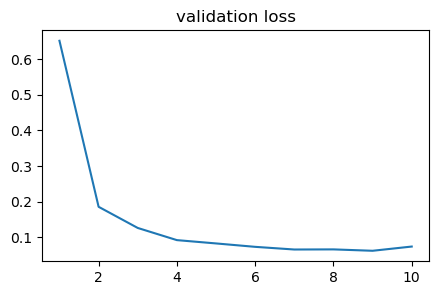

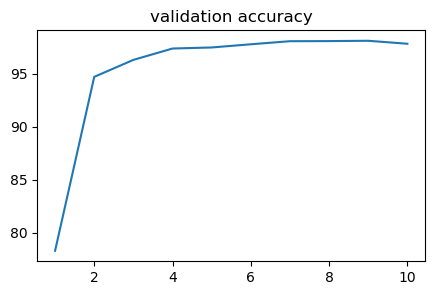

In [58]:
plt.figure(figsize=(5,3))
plt.plot(np.arange(1,epochs+1), lossv)
plt.title('validation loss')

plt.figure(figsize=(5,3))
plt.plot(np.arange(1,epochs+1), accv)
plt.title('validation accuracy');

## Model tuning

Modify the MLP model.  Try to improve the classification accuracy, or experiment with the effects of different parameters.  If you are interested in the state-of-the-art performance on permutation invariant MNIST, see e.g. this [recent paper](https://arxiv.org/abs/1507.02672) by Aalto University / The Curious AI Company researchers.

You can also consult the PyTorch documentation at http://pytorch.org/.